In [1]:
import os
import sys
import random
import math
import re
import time
import numpy as np
import cv2
import matplotlib
import matplotlib.pyplot as plt
import yaml
import skimage.io

from config import Config
import utils
import model as modellib
import visualize
from model import log
from PIL import Image

%matplotlib inline 

# Root directory of the project
ROOT_DIR = os.getcwd()

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

d:\programs\anaconda\envs\python35\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
class HandConfig(Config):
    """Configuration for training on the toy shapes dataset.
    Derives from the base Config class and overrides values specific
    to the toy shapes dataset.
    """
    # Give the configuration a recognizable name
    NAME = "hand"

    # Train on 1 GPU and 8 images per GPU. We can put multiple images on each
    # GPU because the images are small. Batch size is 8 (GPUs * images/GPU).
    GPU_COUNT = 1
    IMAGES_PER_GPU = 2

    # Number of classes (including background)
    NUM_CLASSES = 1 + 1  # background + 3 shapes
    
    # Use small images for faster training. Set the limits of the small side
    # the large side, and that determines the image shape.
    IMAGE_MIN_DIM = 384
    IMAGE_MAX_DIM = 512
    
    
    DETECTION_MIN_CONFIDENCE = 0.85
    RPN_NMS_THRESHOLD = 0.85

    # Use smaller anchors because our image and objects are small
    RPN_ANCHOR_SCALES = (8, 16, 32, 64, 128)  # anchor side in pixels

    # Reduce training ROIs per image because the images are small and have
    # few objects. Aim to allow ROI sampling to pick 33% positive ROIs.
    TRAIN_ROIS_PER_IMAGE = 8

    # Use a small epoch since the data is simple
    STEPS_PER_EPOCH = 10

    # use small validation steps since the epoch is small
    VALIDATION_STEPS = 5
    
config = HandConfig()
config.display()


Configurations:
BACKBONE_SHAPES                [[128 128]
 [ 64  64]
 [ 32  32]
 [ 16  16]
 [  8   8]]
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     2
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.85
DETECTION_NMS_THRESHOLD        0.3
GPU_COUNT                      1
IMAGES_PER_GPU                 2
IMAGE_MAX_DIM                  512
IMAGE_MIN_DIM                  384
IMAGE_PADDING                  True
IMAGE_SHAPE                    [512 512   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
MASK_POOL_SIZE                 14
MASK_SHAPE                     [28, 28]
MAX_GT_INSTANCES               100
MEAN_PIXEL                     [123.7 116.8 103.9]
MINI_MASK_SHAPE                (56, 56)
NAME                           hand
NUM_CLASSES                    2
POOL_SIZE                      7
POST_NMS_ROIS_INFERENCE        1000
POST_NMS_ROIS_TRAINING         

In [3]:
# Create HandDataset
class HandDataset(utils.Dataset):
    def get_obj_index(self, image):
        n = np.max(image)
        return n
    
#     get label names
    def from_yaml_get_class(self,image_id):
        info = self.image_info[image_id]
        with open(info['yaml_path']) as f:
            temp=yaml.load(f.read())
            labels=temp['label_names']
            del labels[0]
        return labels
    
    def draw_mask(self, num_obj, mask, image):
        info = self.image_info[image_id]
        for index in range(num_obj):
            for i in range(info['width']):
                for j in range(info['height']):
                    at_pixel = image.getpixel((i, j))
                    if at_pixel == index + 1:
                        mask[j, i, index] =1
        return mask
    
    def load_shapes(self, count, height, width, img_folder, imglist, dataset_root_path):
        
        # add classes
        self.add_class("object", 1, "hand")
        
        for i in range(count):
            filestr = imglist[i].split(".")[0]
            mask_path = dataset_root_path+"/"+"img_json/"+filestr+"_json/label.png"
            yaml_path = dataset_root_path+"/"+"img_json/"+filestr+"_json/info.yaml"
            self.add_image("object", image_id=i, path=img_folder + "/" + imglist[i],
                           width=width, height=height, mask_path=mask_path,yaml_path=yaml_path)
            
    def load_mask(self, image_id):
        """Generate instance masks for shapes of the given image ID.
        """
        global iter_num
        info = self.image_info[image_id]
        count = 1  # number of object
        img = Image.open(info['mask_path']).convert("L")
        num_obj = self.get_obj_index(img)
        mask = np.zeros([info['height'], info['width'], num_obj], dtype=np.uint8)
        mask = self.draw_mask(num_obj, mask, img)
        occlusion = np.logical_not(mask[:, :, -1]).astype(np.uint8)
        for i in range(count - 2, -1, -1):
            mask[:, :, i] = mask[:, :, i] * occlusion
            occlusion = np.logical_and(occlusion, np.logical_not(mask[:, :, i]))
        labels=[]
        labels=self.from_yaml_get_class(image_id)
        labels_form=[]
        for i in range(len(labels)):
            if labels[i].find("hand")!=-1:
                labels_form.append("hand")
        class_ids = np.array([self.class_names.index(s) for s in labels_form])
        return mask, class_ids.astype(np.int32)

In [4]:
dataset_root_path="./training_set"
img_folder = dataset_root_path+"/image"
imglist = os.listdir(img_folder)
count = len(imglist)
width = 384
height = 512

In [5]:
dataset_train = HandDataset()
dataset_train.load_shapes(count, height, width, img_folder, imglist, dataset_root_path)
dataset_train.prepare()

dataset_val = HandDataset()
dataset_val.load_shapes(count, height, width, img_folder, imglist, dataset_root_path)
dataset_val.prepare()

In [6]:
# Create model in training mode
model = modellib.MaskRCNN(mode="training", config=config,
                          model_dir=MODEL_DIR)

In [7]:
init_with = "imagenet"  # imagenet, coco, or last

if init_with == "imagenet":
    model.load_weights(model.get_imagenet_weights(), by_name=True)
elif init_with == "coco":
    model.load_weights(COCO_MODEL_PATH, by_name=True,
                       exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", 
                                "mrcnn_bbox", "mrcnn_mask"])
elif init_with == "last":
    # Load the last model you trained and continue training
    model.load_weights(model.find_last()[1], by_name=True)

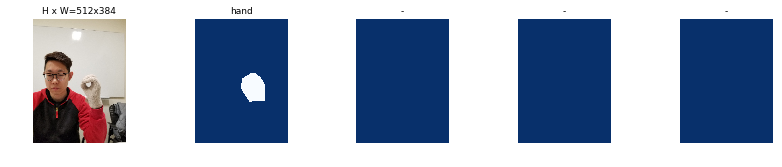

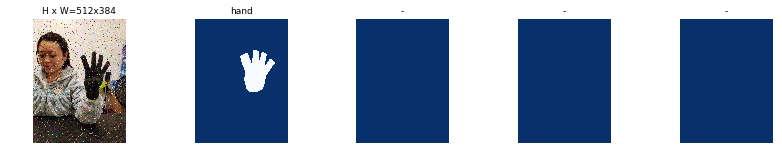

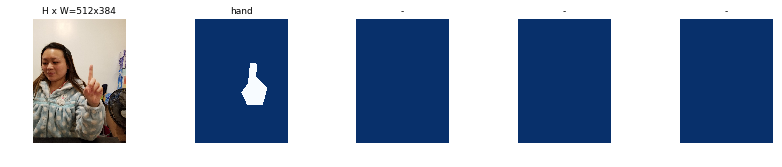

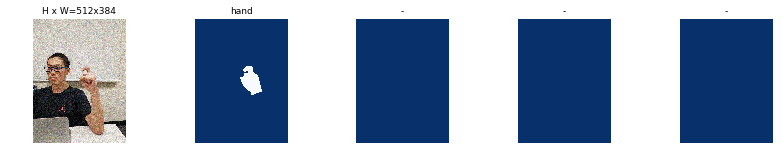

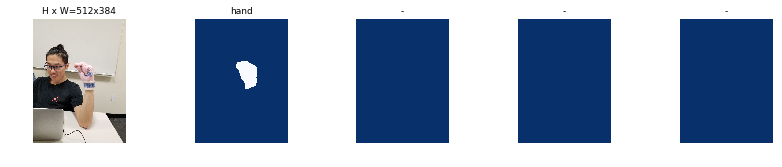

In [8]:
# Load and display random samples
image_ids = np.random.choice(dataset_train.image_ids, 5)
for image_id in image_ids:
    image = dataset_train.load_image(image_id)
    mask, class_ids = dataset_train.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, dataset_train.class_names)

In [ ]:
# Train 'heads' part of model, only the mask layer
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE, 
            epochs=10,
            layers = 'heads')


Starting at epoch 0. LR=0.001

Checkpoint Path: D:\Gesture-Recognition\Mask_RCNN\logs\hand20180318T1350\mask_rcnn_hand_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (TimeDistributed)
mrc

d:\programs\anaconda\envs\python35\lib\site-packages\tensorflow\python\ops\gradients_impl.py:95: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/10


In [70]:
# Train 'all' part, all layers of the model
# model.train(dataset_train, dataset_val, 
#             learning_rate=config.LEARNING_RATE/10, 
#             epochs=2,
#             layers = "all")

In [71]:
# Save weights
model_path = os.path.join(MODEL_DIR, "mask_rcnn_hand.h5")
model.keras_model.save_weights(model_path)

# Evaluate on Test Data

In [72]:
MODEL_PATH = os.path.join("./logs/mask_rcnn_hand.h5")
IMAGE_DIR = os.path.join("./training_set/image")

In [73]:
# Create Test Configuration and Display
class HandTestConfig(HandConfig):
    
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    DETECTION_MIN_CONFIDENCE = 0.85
    RPN_NMS_THRESHOLD = 0.85

config = HandTestConfig()
config.display()


Configurations:
BACKBONE_SHAPES                [[128 128]
 [ 64  64]
 [ 32  32]
 [ 16  16]
 [  8   8]]
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [ 0.1  0.1  0.2  0.2]
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.85
DETECTION_NMS_THRESHOLD        0.3
GPU_COUNT                      1
IMAGES_PER_GPU                 1
IMAGE_MAX_DIM                  512
IMAGE_MIN_DIM                  384
IMAGE_PADDING                  True
IMAGE_SHAPE                    [512 512   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
MASK_POOL_SIZE                 14
MASK_SHAPE                     [28, 28]
MAX_GT_INSTANCES               100
MEAN_PIXEL                     [ 123.7  116.8  103.9]
MINI_MASK_SHAPE                (56, 56)
NAME                           hand
NUM_CLASSES                    2
POOL_SIZE                      7
POST_NMS_ROIS_INFERENCE        1000
POST_NMS_ROIS_TRAINING  

In [74]:
# Create model object in inference mode.
model = modellib.MaskRCNN(mode="inference", model_dir=MODEL_DIR, config=config)

# Load weights trained on MS-COCO
model.load_weights(MODEL_PATH, by_name=True)

In [75]:
class_names = ['BG', 'hand']

Processing 1 images
image                    shape: (512, 384, 3)         min:    0.00000  max:  255.00000
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000
image_metas              shape: (1, 10)               min:    0.00000  max:  512.00000


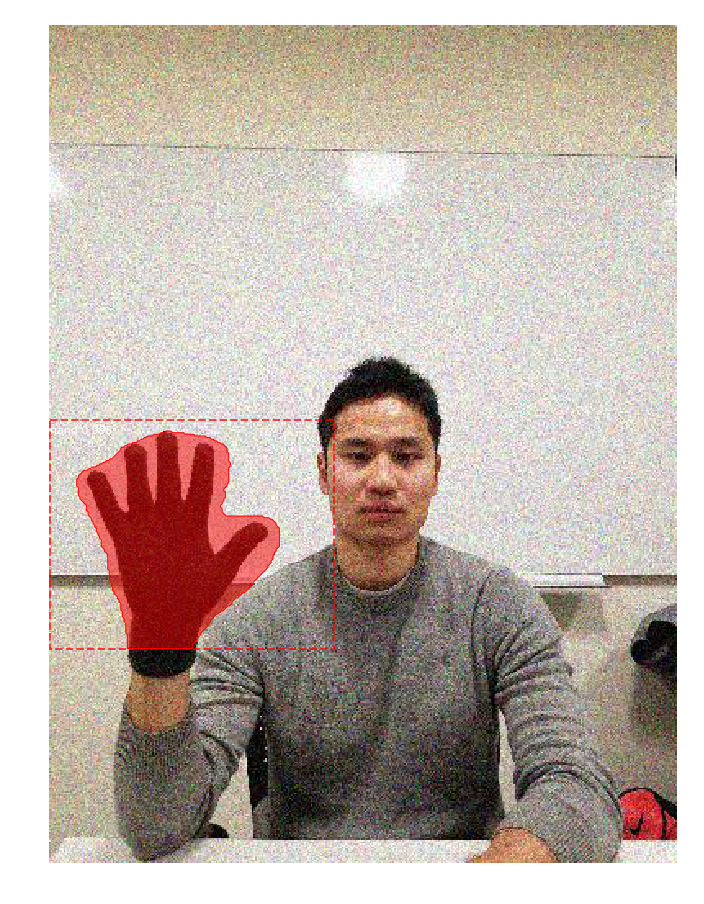

[ 0.99506074]
[241   0 381 174]


In [208]:
# Evaluate on test data
file_name = "0000.jpg"
image = skimage.io.imread(os.path.join(IMAGE_DIR, file_names))
# image = skimage.io.imread("../Test_Set/query_image/test_0007_gau.jpg")
# Run detection
results = model.detect([image], verbose=1)

# Visualize results
r = results[0]
visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], class_names, r['scores'])

# Print the highest score box bound
print(r['scores'])
print(r['rois'][np.argmax(r['scores'])])

# Process Whole Dataset

In [160]:
# Function to detect images
def detect_img(img, model):
    result = model.detect([img])
    r = result[0]
    opt_index = np.argmax(r['scores'])
    roi = r['rois'][opt_index]
    return roi
    

In [161]:
# Function to crop images
def crop_img(img, image, dst, roi):
    h = img.shape[0]
    w = img.shape[1]
    h1 = roi[0]
    w1 = roi[1]
    h2 = roi[2]
    w2 = roi[3]
    
    height = h2-h1
    width = w2-w1
    h_stride = math.ceil(height/4)
    w_stride = math.ceil(width/4)
    
#     adjust height
    if h1-h_stride < 0:
        hu = 0
        hd = h2+h_stride+(h_stride-h1)
    elif h2+h_stride > h:
        hu = h1-h_stride-(h2+h_stride-h)
        hd = h
    else:
        hu = h1-h_stride
        hd = h2+h_stride

#     adjust width  
    if w1-w_stride < 0:
        wl = 0
        wr = w2+w_stride+(w_stride-w1)
    elif w2+w_stride > w:
        wl = w1-w_stride-(w2+w_stride-w)           
        wr = w
    else:
        wl = w1-w_stride
        wr = w2+w_stride
        
#     crop image
    box = (wl, hu, wr, hd)
    img_crop = image.crop(box)
    img_crop.save(dst)

In [162]:
# Function to save cropped images
def save_to_file(img_name, dst_file):
    ori_path = "../Original_Dataset/train_list.txt"
    gau_path = "../Gaussian_Dataset/train_list_gau.txt"
    sap_path = "../Salt&Pepper_Dataset/train_list_sap.txt"
    if len(img_name) == 4:
        ori_file = open(ori_path)
        lines = ori_file.readlines()
        for text in lines:
            if text.strip().split()[0] == img_name:
                dst_file.write(img_name+".jpg"+"-"+text.strip().split()[1]+"\n")
        ori_file.close()
    elif len(img_name) == 8:
        if img_name.split("_")[1] == "gau":
            gau_file = open(gau_path)
            lines = gau_file.readlines()
            for text in lines:
                if text.strip().split()[0] == img_name:
                    dst_file.write(img_name+".jpg"+"-"+text.strip().split()[1]+"\n")
            gau_file.close()
        elif img_name.split("_")[1] == "sap":
            sap_file = open(sap_path)
            lines = sap_file.readlines()
            for text in lines:
                if text.strip().split()[0] == img_name:
                    dst_file.write(img_name+".jpg"+"-"+text.strip().split()[1]+"\n")
            sap_file.close()
            
        

In [163]:
# Generate new training data
img_path = "./training_set/image"
dst_path = "../Training_Set"
if os.path.exists(dst_path) == False:
    os.mkdir(dst_path)
    
train_list = os.path.join(dst_path, "train.list")
train_file = open(train_list, 'w')

# Process each image
img_list = os.listdir(img_path)
for item in img_list:
    if item.endswith(".jpg"):
        current = os.path.join(img_path, item)
        img_dst = os.path.join(dst_path, item)
        
#         crop image
        img = cv2.imread(current)
    
        roi = detect_img(img, model)
        image = Image.open(current)
        crop_img(img, image, img_dst, roi)
        
#         edit train.list and save
        img_name = item.split(".")[0]
        save_to_file(img_name, train_file)

train_file.close()

In [198]:
# img = cv2.imread("./training_set/image/0304_gau.jpg")
# image = Image.open("./training_set/image/0304_gau.jpg")
# roi = detect_img(img, model)
# box = (roi[1], roi[0], roi[3], roi[2])
# crop = image.crop(box)
# crop.save("./0304_gau.jpg")